# Sightlines

We demonstrate the gridding of selected sightlines with `cygrid`. This can be particularly useful if you have some high-resolution data such as QSO absorption spectra and want to get accurate foreground values from a dataset with lower angular resolution.

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`healpy`](http://healpy.readthedocs.org) needs to be available on your machine if you want to re-run the calculations. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [2]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.patches import Circle

import healpy as hp
from astropy.io import fits

import cygrid

## Create dummy data

The properties of the map are given by the ordering and the nside of the map. For more details, check the paper by [Gorski et al. (2005)](http://adsabs.harvard.edu/abs/2005ApJ...622..759G).

In [3]:
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)

The `data` are just random draws from the standard normal distribution. For the `weights`, we choose uniform weighting. The coordinates can be easily calculated with `healpy`.

In [22]:
# data and weights
input_data = np.random.randn(NPIX).astype(np.float32)
weights = np.ones_like(input_data, dtype=np.float32)

# coordinates
theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))
lons = np.rad2deg(phi)
lats = 90. - np.rad2deg(theta)

A quick look confirms that our `data` looks just as expected. 

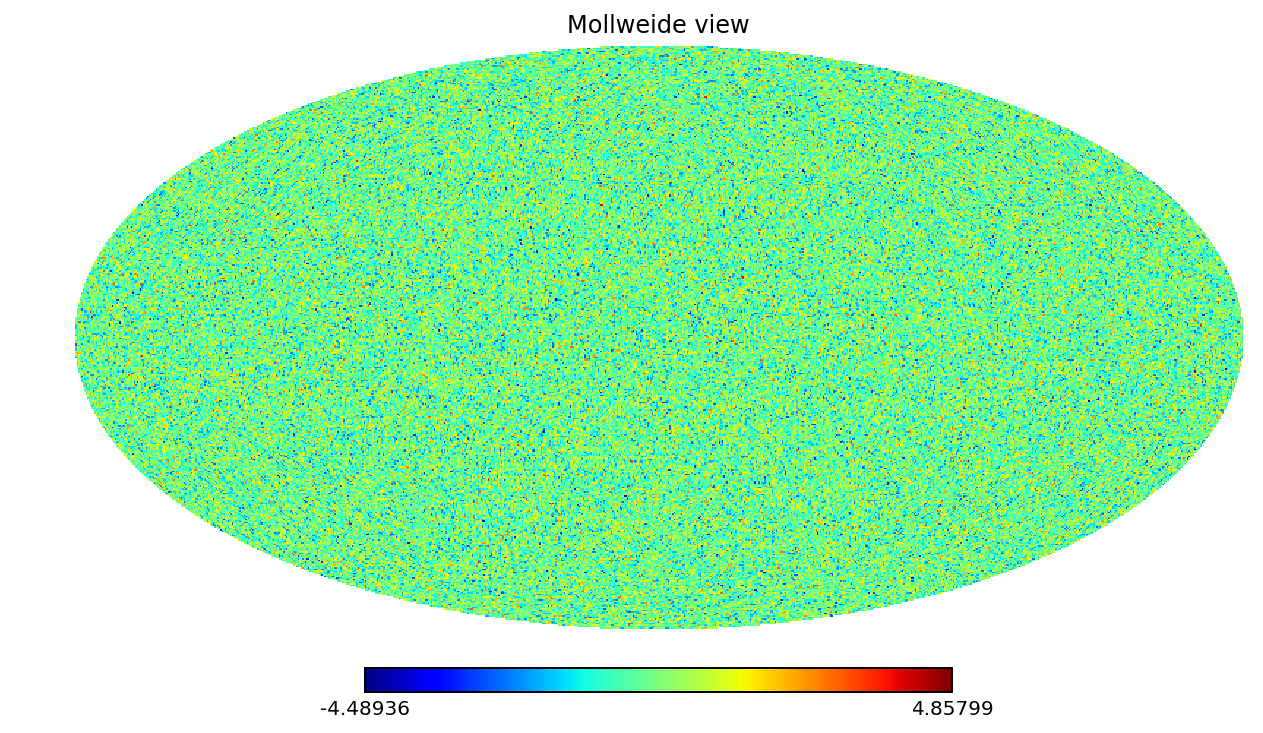

In [23]:
hp.mollview(input_data)

Simple white noise is a bit boring, so let's make it pink by adding a power law to the angular power spectrum. We start by getting the current multipoles and the power spectrum with the `healpy` functions `map2alm` and `alm2cl`.

In [24]:
alms = hp.map2alm(input_data)
cls = hp.alm2cl(alms)
ls = np.arange(cls.shape[0])

Next, we scale the angular power spectrum with a spectral index of 1.5.

In [8]:
cls_pink = cls * ls**(-1.5)
cls_pink[0] = cls_pink[1]

/Users/dlenz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


Here are the angular power spectra for the white and pink noise.

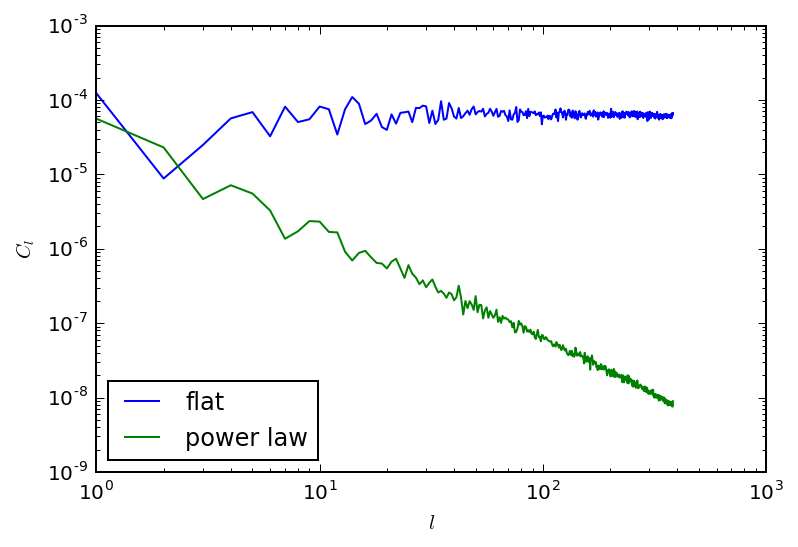

In [25]:
pl.loglog(cls, label='flat')
pl.loglog(cls_pink, label='power law')
pl.legend(loc='lower left')
pl.xlabel(r'$l$')
pl.ylabel(r'$C_l$')

We obtain the Gaussian random field by simply using `synfast` which generates a map, based on the $C_L$.

In [10]:
random_field = hp.synfast(cls_pink, NSIDE, verbose=False)

Looks just like we expected! Time for some gridding now...

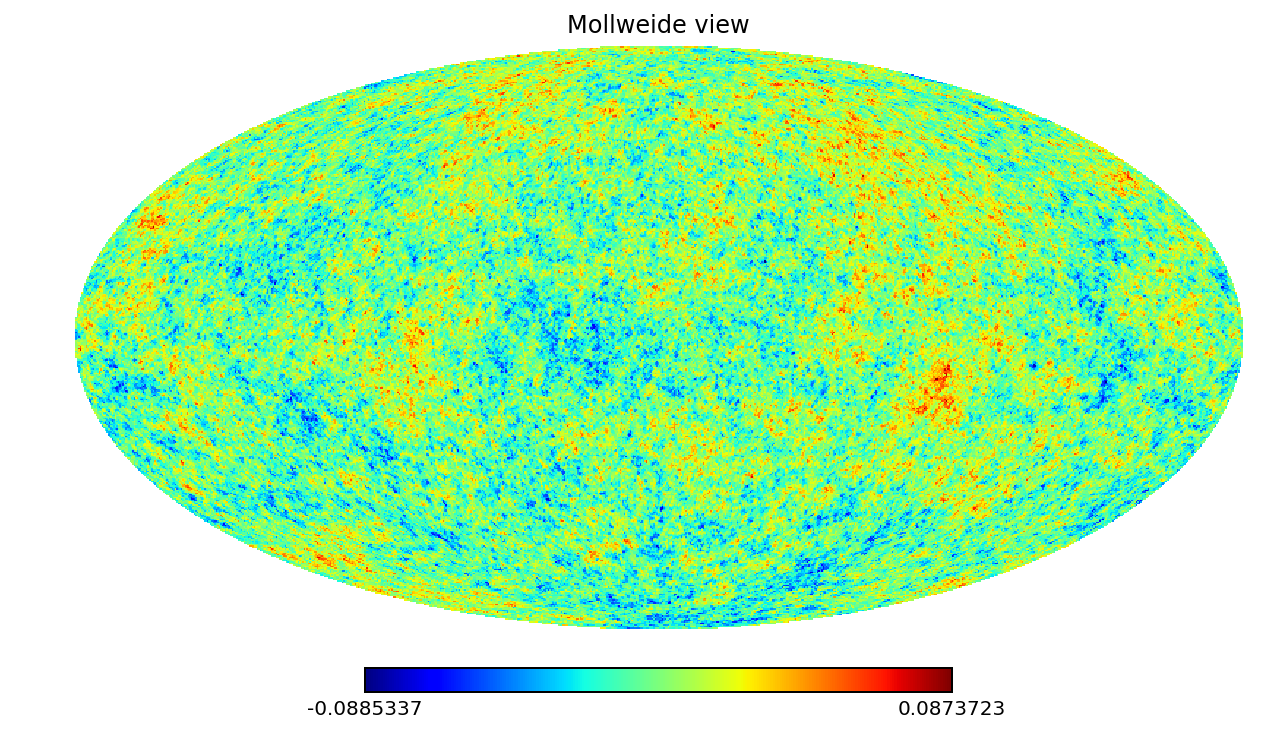

In [11]:
hp.mollview(random_field)

## Gridding

We generate a couple of random $(l, b)$-pairs as target sightlines. The ranges here are $0 < l < 360$ and $-90 < b < 90$.

In [28]:
target_lons = np.random.random(5) * 360.
target_lats = np.random.random(5) * 180. - 90.
print 'lon, lat'
print np.column_stack((target_lons, target_lats))

lon, lat
[[ 201.23776771    6.48515812]
 [ 108.13159718  -28.02059416]
 [ 133.98926134   -2.13288405]
 [ 291.86597318  -10.32082427]
 [  45.8248477    23.5465038 ]]


We initiate the gridder by specifying the target sightlines. The third argument gives the length of the spectral axis, owing to the design of `cygrid` for spectroscopic data. We simply add a degenerate, empty axis of length 1 here.

In [16]:
gridder = cygrid.SlGrid(target_lons, target_lats, 1)

The gridding kernel needs to be set manually. We simply choose a 2D-Gaussian with $1^{\circ}$ FWHM. In that case, we need to furthermore specify `1/kernelsigma^2`, the `kernelradius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsigma/2`.

In [17]:
kernelfwhm = 1.
kernelsigma = kernelfwhm / 2.355
kernelradius = np.float32(3. * kernelsigma)

gridder.set_kernel(
    'gauss1d',
    (1. / kernelsigma ** 2,),
    kernelradius,
    kernelsigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the flattened coordinates, the data, and the weights. For the latter two, we need to provide a second axis.

In [18]:
gridder.grid(lons, lats, data[:, None], weights[:, None])

To get the gridded data, we simply call `get_datacube()`.

In [19]:
datacube = gridder.get_datacube()

Finally, we get a list of our gridded sightlines within the chosen aperture.

In [33]:
print np.column_stack((target_lons, target_lats, np.squeeze(datacube)))

[[  2.01237768e+02   6.48515812e+00   4.01798010e-01]
 [  1.08131597e+02  -2.80205942e+01  -4.71083373e-01]
 [  1.33989261e+02  -2.13288405e+00  -6.03530645e-01]
 [  2.91865973e+02  -1.03208243e+01   4.48439151e-01]
 [  4.58248477e+01   2.35465038e+01  -2.64982104e-01]]
